In [2]:
import numpy as np
import pandas as pd
import os
import random
import sys
import cv2
import matplotlib
from subprocess import check_output

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from google.colab import drive
drive.mount("/content/gdrive/")

def classes_to_int(label):
    label = label.strip()
    if label == "No DR signs":  return 0
    if label == "Mild (or early) NPDR":  return 1
    if label == "Moderate NPDR":  return 2
    if label == "Severe NPDR":  return 3
    if label == "Very Severe NPDR":  return 4
    if label == "PDR":  return 5
    if label == "Advanced PDR":  return 6
    print("Invalid Label", label)
    return 5

def int_to_classes(i):
    if i == 0: return "No DR signs"
    elif i == 1: return "Mild (or early) NPDR"
    elif i == 2: return "Moderate NPDR"
    elif i == 3: return "Severe NPDR"
    elif i == 4: return "Very Severe NPDR"
    elif i == 5: return "PDR"
    elif i == 6: return "Advanced PDR"
    print("Invalid class ", i)
    return "Invalid Class"

Mounted at /content/gdrive/


In [3]:
NUM_CLASSES = 7

#pre-processing size
WIDTH = 128
HEIGHT = 128
DEPTH = 3
inputShape = (HEIGHT, WIDTH, DEPTH)

#epochs to train for (3 times columns), learning rate (default), batch size (default)
EPOCHS = 21
INIT_LR = 0.001
BS = 32

ImageNameDataHash = {}
uniquePatientIDList = []

In [4]:
def preprocessTrainData(trainDir):
  global ImageNameDataHash

  images = os.listdir(trainDir)
  print("# of Files in train: " + str(len(images)))

  for imageFileName in images:
    if (imageFileName == "AnnotationsOfTheClassifications.csv"):
            continue
    imageFullPath = os.path.join(os.path.sep, trainDir, imageFileName)
    img = load_img(imageFullPath)
    arr = img_to_array(img)
    dim1 = arr.shape[0]
    dim2 = arr.shape[1]
    dim3 = arr.shape[2]
    if (dim1 < HEIGHT or dim2 < WIDTH or dim3 < DEPTH):
        print("Error image dimensions are less than expected "+str(arr.shape))
    arr = cv2.resize(arr, (HEIGHT,WIDTH))
    dim1 = arr.shape[0]
    dim2 = arr.shape[1]
    dim3 = arr.shape[2]
    if (dim1 != HEIGHT or dim2 != WIDTH or dim3 != DEPTH):
        print("Error after resize, image dimensions are not equal to expected "+str(arr.shape))
    arr = np.array(arr, dtype="float") / 255.0
    imageFileName = imageFileName.replace('.jpeg','')
    ImageNameDataHash[str(imageFileName)] = np.array(arr)
  return

In [5]:
from datetime import datetime
print("Loading images at..."+ str(datetime.now()))
sys.stdout.flush()
preprocessTrainData("/content/gdrive/My Drive/diabetic/Dataset_from_fundus_images_for_the_study_of_diabetic_retinopathy_V02/")
print("Loaded " + str(len(ImageNameDataHash)) + " images at..."+ str(datetime.now()))

Loading images at...2023-09-05 20:33:25.592893
# of Files in train: 758
Loaded 757 images at...2023-09-05 20:34:16.213108


In [6]:
import csv

def readTrainCsv():
    raw_df = pd.read_csv('/content/gdrive/My Drive/diabetic/Dataset_from_fundus_images_for_the_study_of_diabetic_retinopathy_V02/AnnotationsOfTheClassifications.csv', sep=',')
    print(type(raw_df))
    row_count = raw_df.shape[0]
    col_count = raw_df.shape[1]
    print("row_count =", row_count, "col_count =", col_count)

    raw_df["PatientID"] = ''
    header_list = list(raw_df.columns)
    print(header_list)

    ImageLevelHash = {}
    patientIDList = []

    for index, row in raw_df.iterrows():
        key = row[0]
        patientID = row[0]

        raw_df.at[index, 'PatientID'] = patientID
        patientIDList.append(patientID)
        ImageLevelHash[key] = (row[1])

    global uniquePatientIDList
    uniquePatientIDList = sorted(set(patientIDList))

    count = 0
    for patientID in uniquePatientIDList:
        level = ImageLevelHash[(patientID)]
        count += 1

    print("count of unique patients =", count)
    return raw_df


In [7]:
random.seed(10)
print("Reading trainLabels.csv...")
df = readTrainCsv()

Reading trainLabels.csv...
<class 'pandas.core.frame.DataFrame'>
row_count = 757 col_count = 3
['Image', 'Format', 'Status', 'PatientID']
count of unique patients = 757


In [8]:
for i in range(0,10):
    s = df.loc[df.index[i], 'PatientID']
    print(str(i) + " patient's patientID="+str(s))

0 patient's patientID=1
1 patient's patientID=2
2 patient's patientID=3
3 patient's patientID=4
4 patient's patientID=5
5 patient's patientID=6
6 patient's patientID=7
7 patient's patientID=8
8 patient's patientID=9
9 patient's patientID=10


In [9]:
new_ImageNameDataHash = {}
for key, value in ImageNameDataHash.items():
    new_key = key.replace('.jpg', '')
    new_ImageNameDataHash[new_key] = value

ImageNameDataHash = new_ImageNameDataHash
print(ImageNameDataHash.keys())

keepImages =  list(ImageNameDataHash.keys())

for i in range(len(keepImages)):
    keepImages[i] = keepImages[i].replace('.jpg', '')


df['Image']= df['Image'].map(str)

df = df[df['Image'].isin(keepImages)]
print(len(df))

dict_keys(['100', '102', '101', '10', '1', '123', '143', '128', '109', '122', '138', '146', '113', '13', '107', '127', '135', '133', '106', '112', '12', '14', '139', '120', '136', '121', '131', '129', '134', '144', '124', '104', '105', '137', '119', '117', '115', '132', '103', '11', '118', '141', '114', '125', '147', '140', '108', '126', '130', '145', '111', '116', '142', '110', '2', '151', '18', '175', '187', '180', '149', '168', '153', '152', '185', '163', '182', '166', '155', '154', '165', '19', '169', '177', '178', '150', '157', '179', '176', '16', '148', '183', '186', '17', '20', '184', '162', '170', '172', '21', '173', '160', '15', '164', '159', '158', '181', '171', '156', '161', '174', '167', '48', '4', '54', '35', '61', '58', '39', '40', '26', '50', '23', '25', '57', '60', '53', '42', '36', '51', '29', '41', '33', '22', '37', '32', '52', '38', '31', '3', '62', '5', '30', '63', '28', '49', '43', '55', '6', '56', '44', '24', '34', '47', '45', '59', '46', '27', '192', '64', '92', 

In [10]:

imageNameArr = []
dataArr = []
for index, row in df.iterrows():
    key = str(row[0])
    if key in ImageNameDataHash:
        imageNameArr.append(key)
        dataArr.append(np.array(ImageNameDataHash[key]))

df2 = pd.DataFrame({'image': imageNameArr, 'Data': dataArr})
df2_header_list = list(df2.columns)
print(df2_header_list)
print(len(df2))

['image', 'Data']
757


In [11]:
if len(df) != len(df2):
    print("Error length of df != df2")

for idx in range(0,len(df)):
    if (df.loc[df.index[idx], 'Image'] != df2.loc[df2.index[idx], 'image']):
        print("Error " + df.loc[df.index[idx], 'image'] +"==" + df2.loc[df2.index[idx], 'image'])

print(df2.dtypes)
print(df.dtypes)

image    object
Data     object
dtype: object
Image        object
Format       object
Status       object
PatientID    object
dtype: object


In [12]:
df = pd.merge(df2, df, left_on='image', right_on='Image', how='outer')
df_header_list = list(df.columns)
print(df_header_list)
print(len(df))
print(df.sample())

['image', 'Data', 'Image', 'Format', 'Status', 'PatientID']
757
    image                                               Data Image Format  \
713   714  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   714    jpg   

           Status PatientID  
713  Advanced PDR       714  


[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
<class 'numpy.ndarray'>
(128, 128, 3)


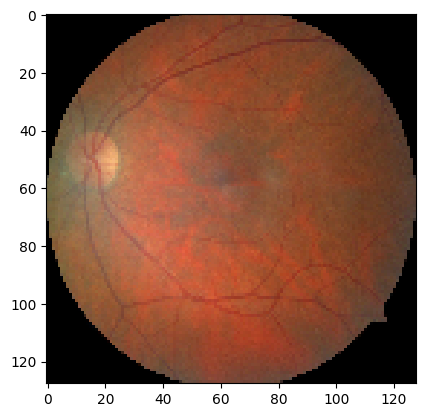

Sample Image


In [13]:
sample0 = df.loc[df.index[0], 'Data']
print(sample0)
print(type(sample0))
print(sample0.shape)
from matplotlib import pyplot as plt
plt.imshow(sample0, interpolation='nearest')
plt.show()
print("Sample Image")

In [14]:
X = df['Data']
df['Status'] = df['Status'].apply(classes_to_int)
Y = df['Status']

Y = np.array(Y)

Y =  to_categorical(Y, num_classes=NUM_CLASSES)

In [15]:
print(df)

    image                                               Data Image Format  \
0       1  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...     1    jpg   
1       2  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...     2    jpg   
2       3  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...     3    jpg   
3       4  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...     4    jpg   
4       5  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...     5    jpg   
..    ...                                                ...   ...    ...   
752   753  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   753    jpg   
753   754  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   754    jpg   
754   755  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   755    jpg   
755   756  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   756    jpg   
756   757  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   757    jpg   

     Status PatientID  
0         0         1  
1         0         2  
2  

In [16]:
print("Parttition data into 75:25...")
sys.stdout.flush()
print("Unique patients in dataframe df=" + str(df.PatientID.nunique()))
unique_ids = df.PatientID.unique()
print('unique_ids shape='+ str(len(unique_ids)))

train_ids, valid_ids = train_test_split(unique_ids, test_size = 0.25, random_state = 10)
trainid_list = train_ids.tolist()
print('trainid_list shape=', str(len(trainid_list)))

traindf = df[df.PatientID.isin(trainid_list)]
valSet = df[~df.PatientID.isin(trainid_list)]

Parttition data into 75:25...
Unique patients in dataframe df=757
unique_ids shape=757
trainid_list shape= 567


In [17]:
print(traindf.head())
print(valSet.head())

traindf = traindf.reset_index(drop=True)
valSet = valSet.reset_index(drop=True)

print(traindf.head())
print(valSet.head())

  image                                               Data Image Format  \
0     1  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...     1    jpg   
2     3  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...     3    jpg   
3     4  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...     4    jpg   
4     5  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...     5    jpg   
5     6  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...     6    jpg   

   Status PatientID  
0       0         1  
2       0         3  
3       0         4  
4       0         5  
5       0         6  
   image                                               Data Image Format  \
1      2  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...     2    jpg   
6      7  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...     7    jpg   
7      8  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...     8    jpg   
12    13  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...    13    jpg   
22    23  [[[0.0, 0.0, 0.0], [0.0, 0.

In [18]:
trainX = traindf['Data']
trainY = traindf['Status']

valX = valSet['Data']
valY = valSet['Status']

print('trainX shape=', trainX.shape[0], 'valX shape=', valX.shape[0])

trainX shape= 567 valX shape= 190


In [19]:
trainY =  to_categorical(trainY, num_classes=NUM_CLASSES)
valY =  to_categorical(valY, num_classes=NUM_CLASSES)

In [20]:
print("Generating images...")
sys.stdout.flush()
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, \
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,\
    horizontal_flip=True, fill_mode="nearest")

Generating images...


In [21]:
def createModel():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=inputShape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=NUM_CLASSES, activation='softmax'))
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [22]:
print("Reshaping trainX at..."+ str(datetime.now()))
print(type(trainX))
print(trainX.shape)
from numpy import zeros
Xtrain = np.zeros([trainX.shape[0],HEIGHT, WIDTH, DEPTH])
for i in range(trainX.shape[0]):
    Xtrain[i] = trainX[i]
print(Xtrain.shape)
print("Reshaped trainX at..."+ str(datetime.now()))

Reshaping trainX at...2023-09-05 20:34:53.370307
<class 'pandas.core.series.Series'>
(567,)
(567, 128, 128, 3)
Reshaped trainX at...2023-09-05 20:34:53.499738


In [23]:
print("Reshaping valX at..."+ str(datetime.now()))
print(type(valX))
print(valX.shape)
from numpy import zeros
Xval = np.zeros([valX.shape[0],HEIGHT, WIDTH, DEPTH])
for i in range(valX.shape[0]):
    Xval[i] = valX[i]
print(Xval.shape)
print("Reshaped valX at..."+ str(datetime.now()))

Reshaping valX at...2023-09-05 20:34:53.509722
<class 'pandas.core.series.Series'>
(190,)
(190, 128, 128, 3)
Reshaped valX at...2023-09-05 20:34:53.557427


compiling model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        36928     
                                     

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


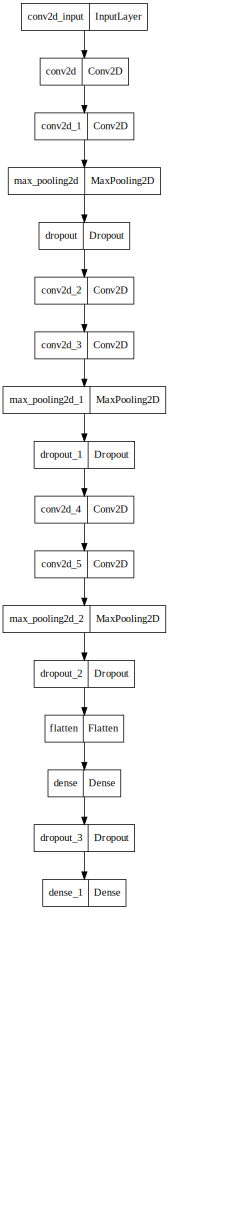

In [24]:
print("compiling model...")
sys.stdout.flush()
model = createModel()

model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [25]:
print("training network...")
sys.stdout.flush()

H = model.fit_generator(aug.flow(Xtrain, trainY, batch_size=BS), \
    validation_data=(Xval, valY), \
    steps_per_epoch=len(trainX) // BS, \
    epochs=EPOCHS, verbose=1)

print("Saving model to disk")
sys.stdout.flush()
model.save("/content/gdrive/My Drive/diabetic/mymodel")

training network...


<ipython-input-25-9269744c974f>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(aug.flow(Xtrain, trainY, batch_size=BS), \


Epoch 1/21
17/17 [==============================] - 15s 278ms/step - loss: 1.8975 - accuracy: 0.2579 - val_loss: 1.7949 - val_accuracy: 0.2684
Epoch 2/21
17/17 [==============================] - 2s 131ms/step - loss: 1.7521 - accuracy: 0.2822 - val_loss: 1.7286 - val_accuracy: 0.3579
Epoch 3/21
17/17 [==============================] - 2s 131ms/step - loss: 1.6801 - accuracy: 0.3776 - val_loss: 1.7183 - val_accuracy: 0.3684
Epoch 4/21
17/17 [==============================] - 4s 245ms/step - loss: 1.6129 - accuracy: 0.4019 - val_loss: 1.7380 - val_accuracy: 0.3579
Epoch 5/21
17/17 [==============================] - 4s 203ms/step - loss: 1.5857 - accuracy: 0.4075 - val_loss: 1.5746 - val_accuracy: 0.4158
Epoch 6/21
17/17 [==============================] - 2s 133ms/step - loss: 1.5830 - accuracy: 0.4075 - val_loss: 1.5976 - val_accuracy: 0.4053
Epoch 7/21
17/17 [==============================] - 2s 130ms/step - loss: 1.5604 - accuracy: 0.3907 - val_loss: 1.5947 - val_accuracy: 0.4158
Epoch

In [26]:
print("Generating plots...")
sys.stdout.flush()
matplotlib.use("Agg")
matplotlib.pyplot.style.use("ggplot")
matplotlib.pyplot.figure()
N = EPOCHS
matplotlib.pyplot.plot(np.arange(0, N), H.history["loss"], label="train_loss")
matplotlib.pyplot.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
matplotlib.pyplot.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
matplotlib.pyplot.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
matplotlib.pyplot.title("Training Loss and Accuracy on diabetic retinopathy detection")
matplotlib.pyplot.xlabel("Epoch #")
matplotlib.pyplot.ylabel("Loss/Accuracy")
matplotlib.pyplot.legend(loc="lower left")
matplotlib.pyplot.savefig("/content/gdrive/My Drive/diabetic/mymodel/plot.png")

Generating plots...


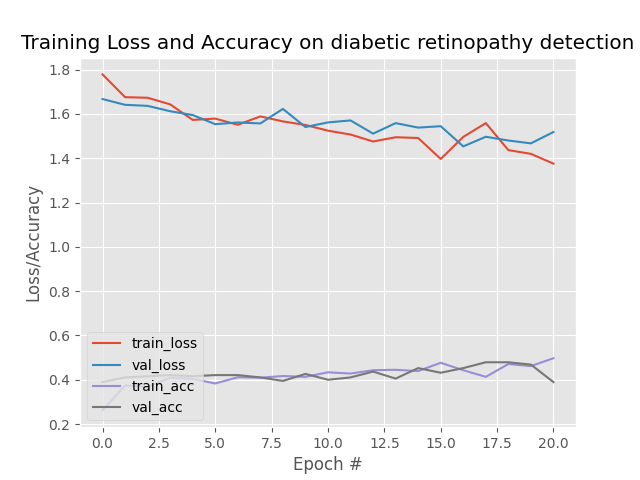

In [27]:
def evaluate_model(model, X_test, y_test):
    eval_dict = model.evaluate(X_test, y_test, return_dict=True)

    display_df = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())])

    return display_df

# Evaluate model on test set and add results to dataframe
results = evaluate_model(model, Xtrain, trainY)

# Set index to 'Baseline'
results.index = ['Baseline']

# Display results
results.head()

18/18 [==============================] - 0s 16ms/step - loss: 1.4431 - accuracy: 0.4991


,loss,accuracy
Baseline,1.443089,0.499118
